## _New York City Airbnb Open Data_  

https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

---

### **0. Import library**

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import *
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')
plt.style.use('seaborn')

---

### **1. Load Data**

In [25]:
df = pd.read_csv("AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


- ``id`` listing ID
- ``name`` name of the listing
- ``host_id`` host ID
- ``host_name`` name of the host
- ``neighbourhood_group`` location
- ``neighbourhood`` area
- ``latitude`` latitude coordinates
- ``longitude`` longitude coordinates
- ``room_type`` listing space type
- ``price price`` in dollars
- ``minimum_nights`` amount of nights minimum
- ``number_of_review`` snumber of reviews
- ``last_review`` latest review
- ``reviews_per_month`` number of reviews per month
- ``calculated_host_listings_count`` amount of listing per host
- ``availability_365`` number of days when listing is available for booking

In [26]:
# 48895개의 row
# 16개의 column
print(df.shape)

(48895, 16)


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

---

### **2. EDA & Preprocessing**

**Target Distribution**

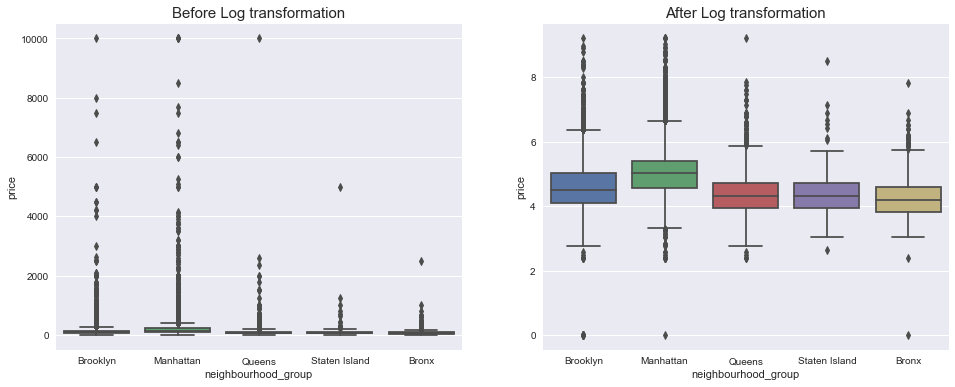

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x=df['neighbourhood_group'], y=(df['price']), ax=axes[0])
axes[0].set_title("Before Log transformation", size=15)

sns.boxplot(x=df['neighbourhood_group'], y=np.log1p(df['price']), ax=axes[1])
axes[1].set_title("After Log transformation", size=15)

plt.show()

# 반응변수를 log 변환한 price를 두고 예측해보는 것도 좋을 것 같다.
# 현재 price의 분포는 우측꼬리가 매우 긴 형태 + 극단치가 많이 존재하는 경우라서
# 회귀계수가 극단치에 의해 변동될 가능성이 농후하기 때문이다.

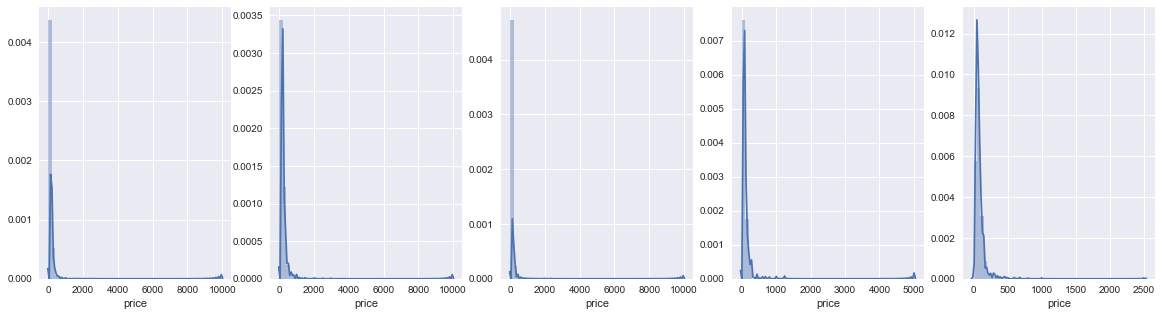

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
for i, group in enumerate(df['neighbourhood_group'].unique()):
    sns.distplot( df.loc[df['neighbourhood_group']==group, 'price'] , ax=axes[i])

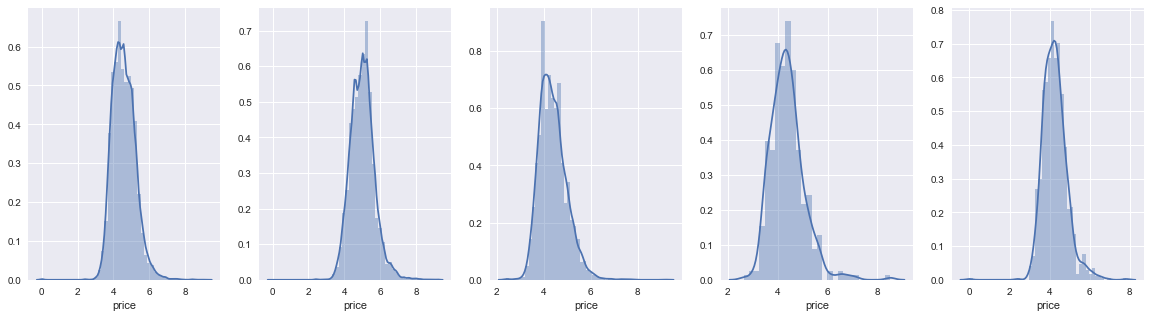

In [30]:
log_price = np.log1p(df['price'])
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
for i, group in enumerate(df['neighbourhood_group'].unique()):
    sns.distplot( log_price[df['neighbourhood_group']==group] , ax=axes[i])

In [31]:
# 결측치 정보 확인
df.isnull().sum()[df.isnull().sum() !=0]

name                    16
host_name               21
last_review          10052
reviews_per_month    10052
dtype: int64

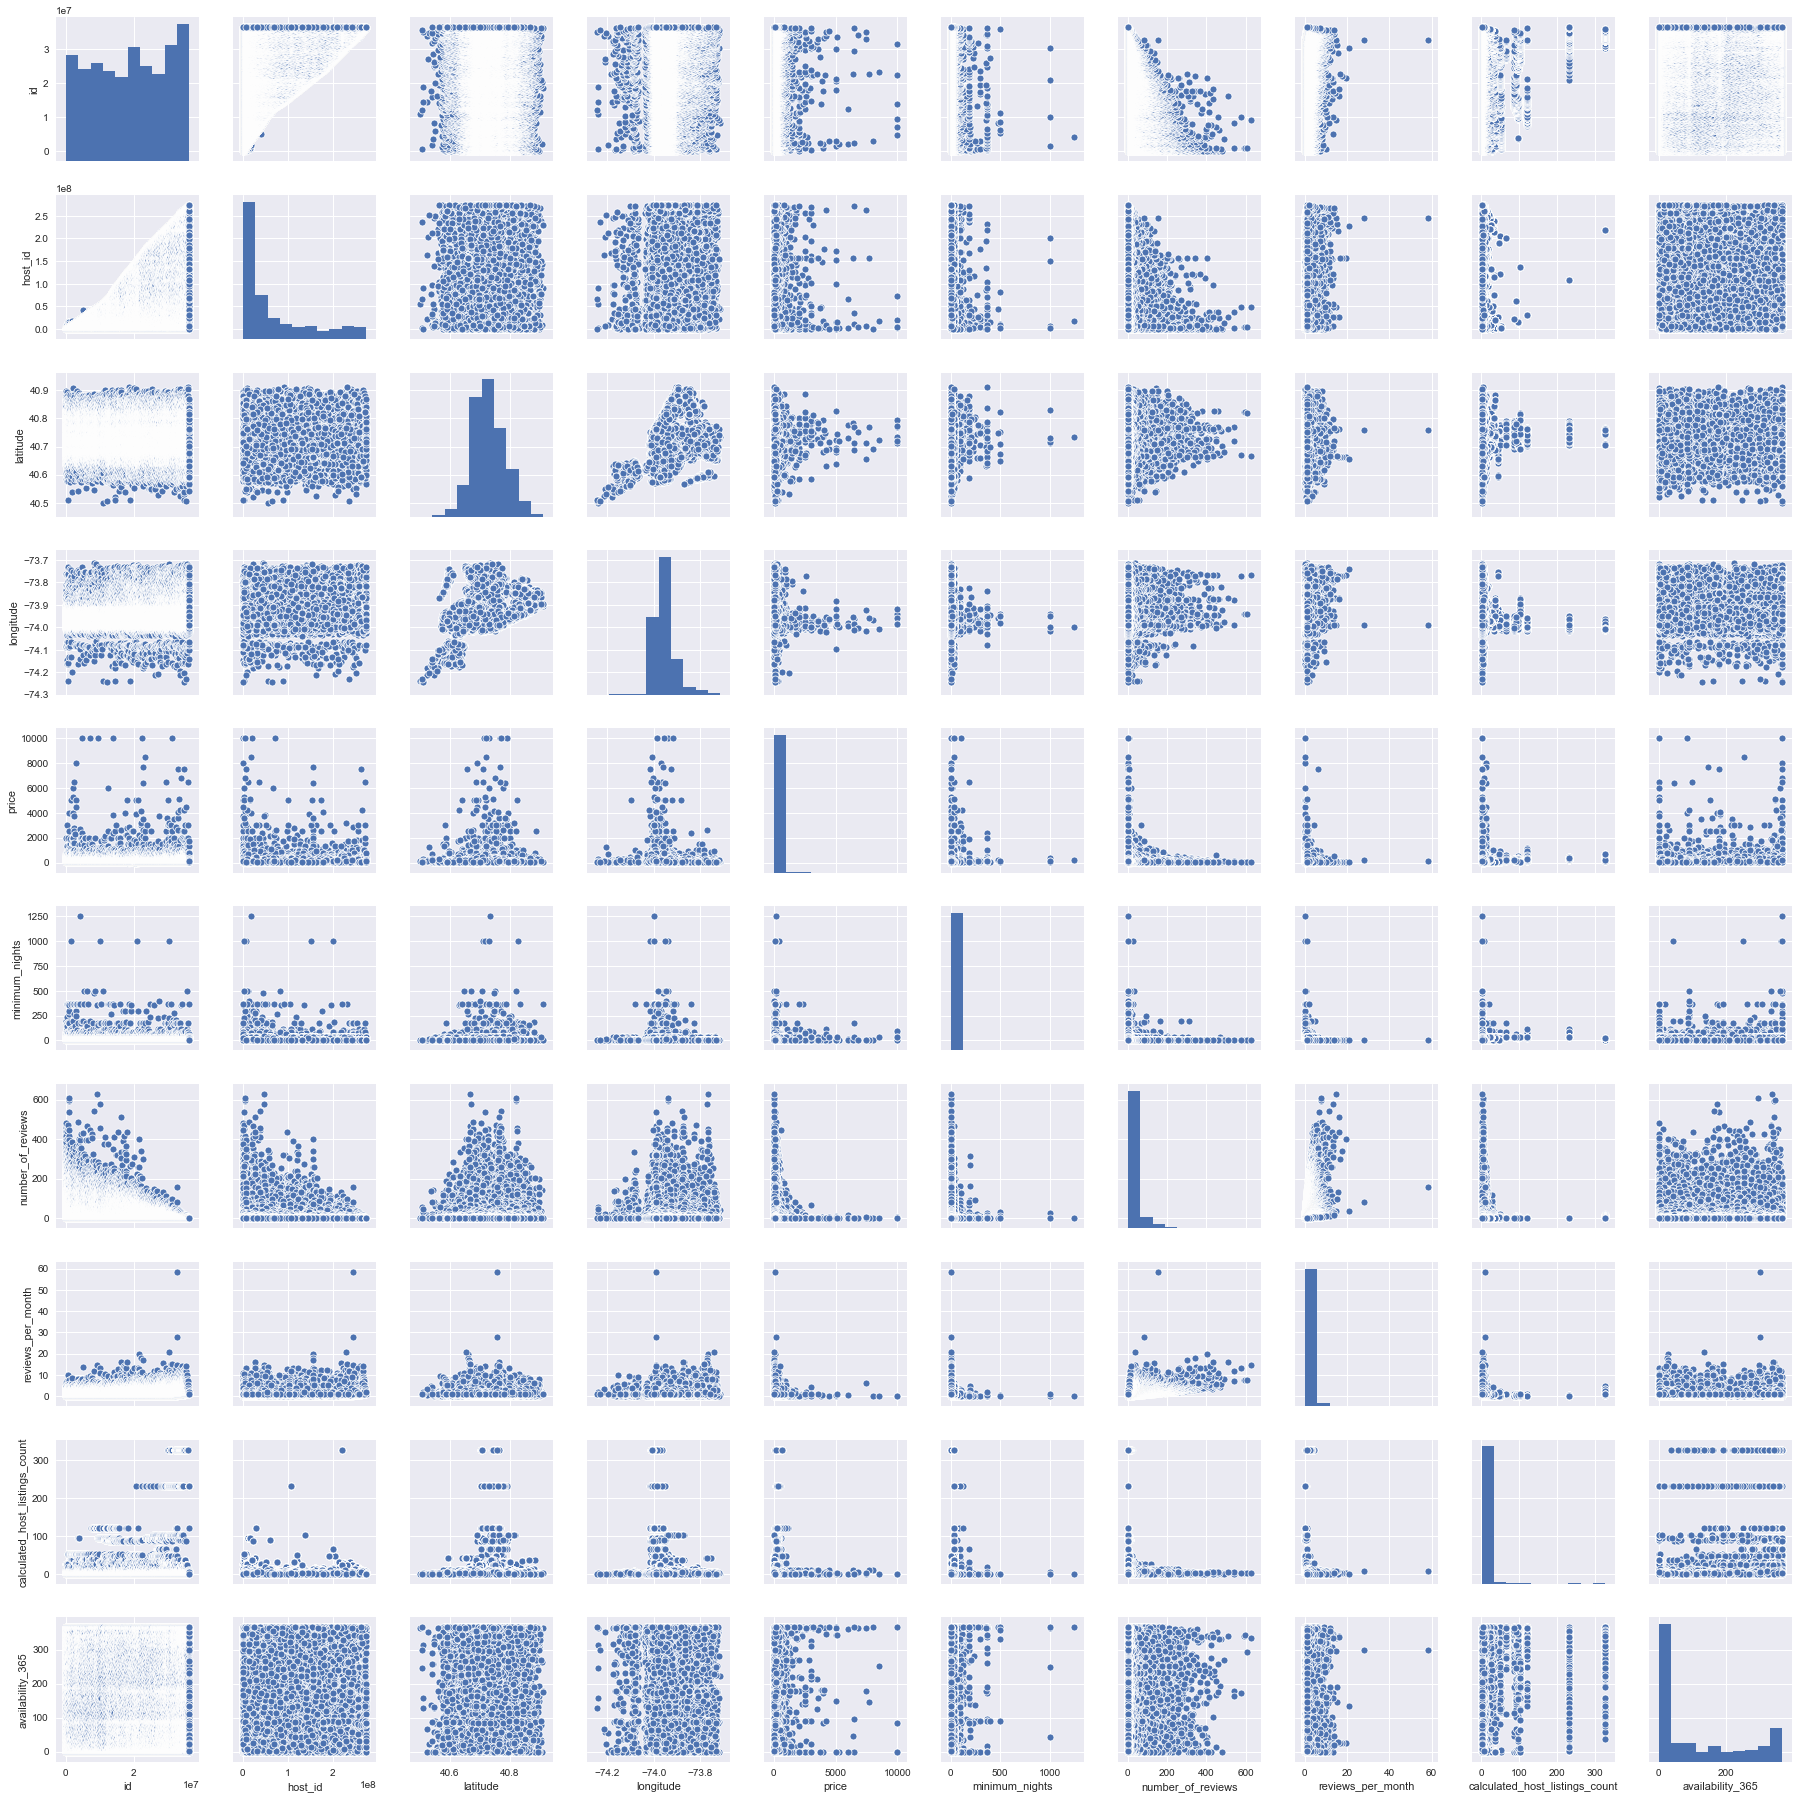

In [32]:
sns.pairplot(df)

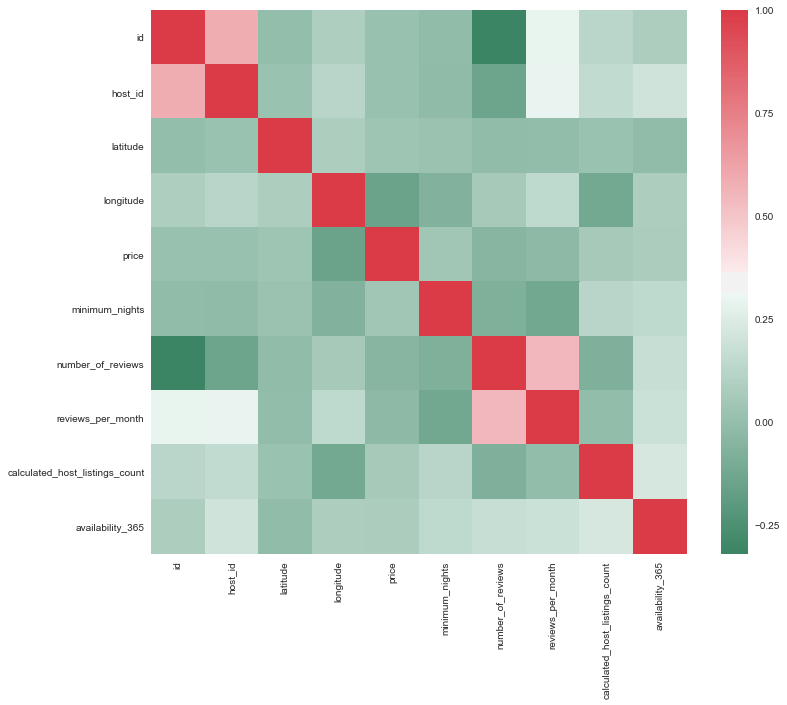

In [33]:
cmap = sns.diverging_palette(150, 10, as_cmap=True)
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap=cmap)

# numer_of_review와 reviews_per_month의 상관계수가 높다
# 상관계수가 높은 feature를 VIF를 높이는 주범이다. 
# 이는 회귀계수의 왜곡을 초래하고, 회귀계수 추정량의 분산과 회귀계수의 norm을 크게 만들기 때문에
# 제거를 고려해보아야 한다. (무조건 제거해야 하는 건 아니다.)

_**host_name 변수 처리**_

In [34]:
# host_name을 대신할 host_id feature가 있으므로 drop
# (또한 host_name으로 price가 결정된다는 생각 자체가 웃긴 것 같다.)

df.drop('host_name', axis=1, inplace=True)

_**reviews_per_month 변수 처리**_

In [35]:
# last_review가 결측치인 경우와 reviews_per_month가 결측치인 경우가 동일
# -> review를 남길 수 없는 경우라서 review에 대한 정보가 없을것이라 판단

print((df['last_review'].isnull() & df['reviews_per_month'].isnull()).sum())

10052


In [36]:
# 리뷰가 있냐 없냐에 따라서 0, 1의 값을 갖는 binary 파생변수 생성
# 리뷰가 있는 경우에 price가 더 높을 것이라고 가설을 세운다.

review = df['reviews_per_month'].apply(lambda x:1 if x>0 else 0)
df['review'] = review

In [37]:
# reviews_per_month의 결측치는 0으로 대체

df['reviews_per_month'].fillna(0, inplace=True)

_**last_review 변수 처리**_

In [38]:
# datetime형으로 변환
df['last_review'] = df['last_review'].apply(pd.to_datetime)

# 가장 최근의 last reivew 날짜를 기준으로 가장 최근의 review가 며칠이나 지났는 지 확인
last_review_days = df['last_review'].max() - df['last_review']
last_review_days = last_review_days.apply(lambda x:x.days)

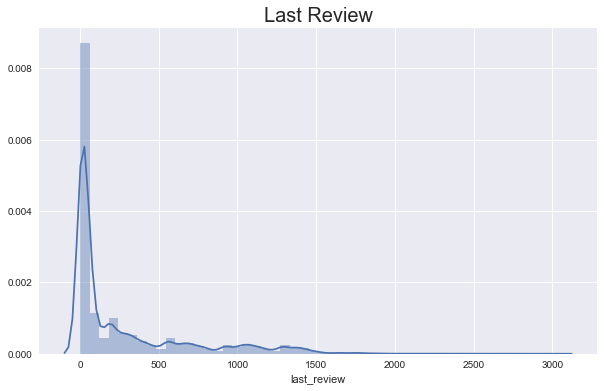

In [39]:
# 대부분의 경우 최근에 reivew가 작성된 적이 있다.
# 마지막 review가 매우 오래전에 기록된 경우일수록 price가 비교적 낮을 것이라고 예상한디.

plt.figure(figsize=(10, 6))
plt.title("Last Review", size=20)
sns.distplot(last_review_days[last_review_days.notnull()])

In [40]:
# 극단치가 많아서 평균으로 대체하기 보다는 중위수로 결측치를 대체하기로 결정
# (평균은 극단치에 민감한 통계량이기 때문에 이렇게 우측꼬리가 긴 경우에 평균보다 중위수로 대체하는 것이 더 나을 것이라 판단)

last_review_days.fillna(last_review_days.median(), inplace=True)

In [41]:
# 새롭게 만든 변수를 dataframe에 반영하였다.

df['last_review_days'] = last_review_days
df.drop('last_review', axis=1, inplace=True)

In [42]:
# 이제는 object형의 데이터를 전처리 하겠다.

df.dtypes

id                                  int64
name                               object
host_id                             int64
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
review                              int64
last_review_days                  float64
dtype: object

#### _**범주형 변수 Encoding**_

_**1. neighbourhood_group**_

In [43]:
# hotel이 어느 지역에 있는 지
# Brooklyn과 Manhattan 지역이 다른 지역에 비해 압도적으로 차지하는 비율이 높다.

df['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

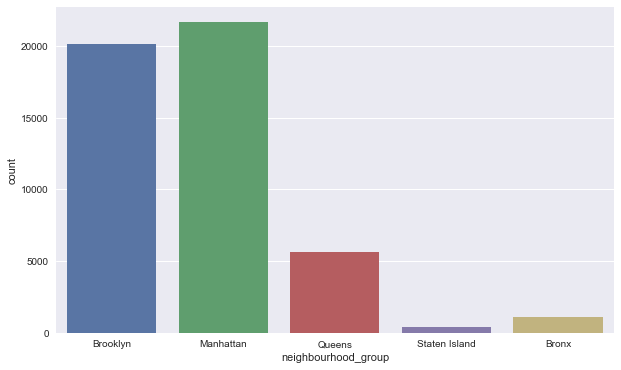

In [44]:
# 데이터에서 지역의 분포를 countplot을 통해 확인해보았다.
# Brooklyn과 Manhattan 지역이 다른 지역에 비해 압도적으로 차지하는 비율이 높다.

plt.figure(figsize=(10, 6))
sns.countplot(df['neighbourhood_group'])

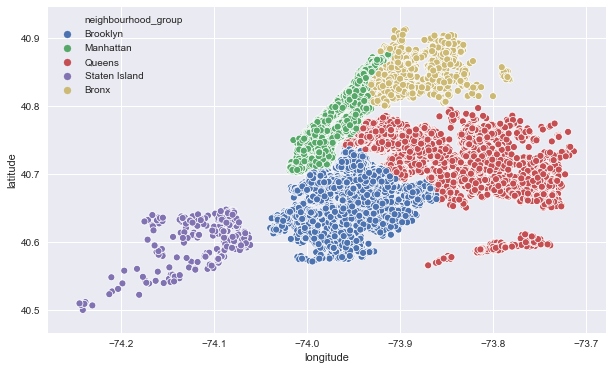

In [45]:
# 다양하게 퍼져있는 데이터셋임을 확인하였다.
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=df['neighbourhood_group'])
plt.show()

In [46]:
# 지역별로 묶고 price의 기초통계량에 대해서 확인해보았다.
# brooklyn과 manhattan이 다른 지역에 비해 상대적으로 가격이 높게 형성되어있음을 확인할 수 있었다.
# 시간이 된다면 교호작용항도 만들어서 회귀계수가 어떻게 다른지 비교해보는 것도 재미있을 것 같다.

# 모든 지역에서 중위수보다 평균이 큰 것으로 보아 우측꼬리가 긴 형태의 분포를 따르고 있음을 다시 한 번 확인할 수 있다.
# (위에서 price의 분포를 그려보았을 때도 우측꼬리가 길어서 log변환을 시도해보지 않았는가?)
# 아무래도 낮은쪽으로 가격이 형성되어있기 보다는 높은쪽으로 극단치가 많이 존재하기 때문에 당연하다.
# (실제로 많은 사회데이터는 우측꼬리가 긴 형태가 많다. 그래서 일반적으로 log변환을 많이 취해보는 것이기도 하고.)

df.groupby(by='neighbourhood_group')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Bronx,1091.0,87.496792,106.709349,0.0,45.0,65.0,99.0,2500.0
Brooklyn,20104.0,124.383207,186.873538,0.0,60.0,90.0,150.0,10000.0
Manhattan,21661.0,196.875814,291.383183,0.0,95.0,150.0,220.0,10000.0
Queens,5666.0,99.517649,167.102155,10.0,50.0,75.0,110.0,10000.0
Staten Island,373.0,114.812332,277.620403,13.0,50.0,75.0,110.0,5000.0


_**2. host_id**_

In [47]:
# 여러개의 hotel을 등록한 경우도 보인다.
df['host_id'].value_counts()[:10]

219517861    327
107434423    232
30283594     121
137358866    103
12243051      96
16098958      96
61391963      91
22541573      87
200380610     65
7503643       52
Name: host_id, dtype: int64

In [48]:
df.drop('host_id', axis=1, inplace=True)

_**3. Room Type**_

Text(0.5, 1.0, 'Room Type')

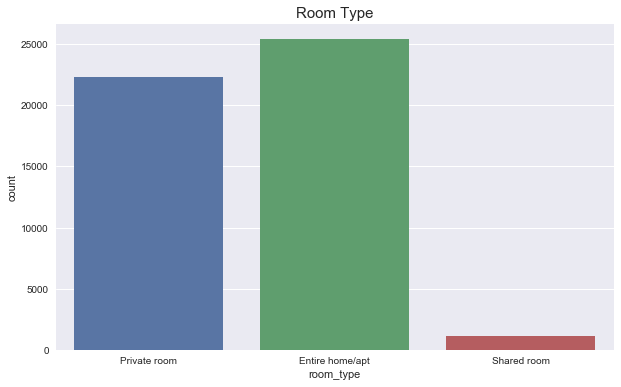

In [49]:
# room type에 대한 분포를 확인해보자.
# entire home > private > shared 순서로 빈도가 높았다.
# (shared room의 경우 비교적 매우 적은 건수만 존재한다.)

plt.figure(figsize=(10, 6))
sns.countplot(df['room_type'])
plt.title('Room Type', size=15)

In [50]:
# room type에 따라서 price 차이가 나는 것도 확인하였다.
# entire home > private room > shared room 으로 가격이 형성되었다. (우리의 직관과 일치)
# room type을 encoding하여 모델 학습 시 사용하기도 결정

df.groupby(by='room_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,25409.0,211.794246,284.041611,0.0,120.0,160.0,229.0,10000.0
Private room,22326.0,89.780973,160.205262,0.0,50.0,70.0,95.0,10000.0
Shared room,1160.0,70.127586,101.725252,0.0,33.0,45.0,75.0,1800.0


In [51]:
# one-hot encoding하여 모델학습 시 feature로 사용하도록 한다.

neighbourhood_group = pd.get_dummies(df['neighbourhood_group'])
neighbourhood = pd.get_dummies(df['neighbourhood'])
roomtype = pd.get_dummies(df['room_type'])

df.drop(['neighbourhood_group', 'neighbourhood', 'room_type'], axis=1, inplace=True)
df = pd.concat([df, neighbourhood_group, neighbourhood, roomtype], axis=1)

_**4. name**_

In [52]:
# name이 결측치인 경우 16개
df['name'].isnull().sum()

16

In [53]:
# name이 결측치인 경우 제거 (전체데이터에 비해 차지하는 비중이 매우 적어 제거하였다.)
# (혹시 text도 imputation하는 방법이 있나 나중에 찾아보도록 하겠다!)

df = df[df['name'].notnull()]

In [54]:
df.head()

,id,name,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,...,Williamsburg,Willowbrook,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Woodside,Entire home/apt,Private room,Shared room
0,2539,Clean & quiet apt home by the park,40.64749,-73.97237,149,1,9,0.21,6,365,...,0,0,0,0,0,0,0,0,1,0
1,2595,Skylit Midtown Castle,40.75362,-73.98377,225,1,45,0.38,2,355,...,0,0,0,0,0,0,0,1,0,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,40.80902,-73.94190,150,3,0,0.00,1,365,...,0,0,0,0,0,0,0,0,1,0
3,3831,Cozy Entire Floor of Brownstone,40.68514,-73.95976,89,1,270,4.64,1,194,...,0,0,0,0,0,0,0,1,0,0
4,5022,Entire Apt: Spacious Studio/Loft by central park,40.79851,-73.94399,80,10,9,0.10,1,0,...,0,0,0,0,0,0,0,1,0,0


In [55]:
# preprocessing 후 데이터셋 크기
df.shape

(48879, 241)

---

In [57]:
# feature와 target으로 나누고 train test로 나누었다.

X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**name 변수 처리**

In [59]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df=3)

In [60]:
tfidf_vectorizer.fit(X_train['name'])
train_name = tfidf_vectorizer.transform(X_train['name'])
test_name  = tfidf_vectorizer.transform(X_test['name'])

In [61]:
train_name.toarray().shape

(34215, 2191)

In [120]:
pca = PCA()
pca.fit(train_name.toarray())

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [121]:
pca.explained_variance_ratio_[:250].sum()

0.7195010963458257

In [63]:
# 차원이 너무 커서 250개의 feature로 PCA를 진행하여 사용하도록 하겠다.
pca = PCA(n_components=250)
pca.fit(train_name.toarray())
train_name_pca = pca.transform(train_name.toarray())
test_name_pca = pca.transform(test_name.toarray())

In [64]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [65]:
X_train.drop('name', axis=1, inplace=True)
X_test.drop('name', axis=1, inplace=True)

X_train = pd.concat([X_train, pd.DataFrame(train_name_pca)], axis=1)
X_test  = pd.concat([X_test, pd.DataFrame(test_name_pca)], axis=1)

In [66]:
print(X_train.shape)
print(X_test.shape)

(34215, 489)
(14664, 489)


In [130]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train_noName, X_test_noName, y_train_noName, y_test_noName = train_test_split(X, y, test_size = 30)

---

## **3. Modeling**

**Linear Regression**

In [69]:
linear = LinearRegression()
linear.fit(X_train, y_train)
pred = linear.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, pred))) 

324.744418411097


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns

In [103]:
vif.sort_values(by='VIF Factor', ascending=False)[14:30]

,VIF Factor,features
226,inf,Westerleigh
13,9.007199e+15,Queens
80,9.007199e+15,Eastchester
152,9.007199e+15,Murray Hill
20,9.007199e+15,Bath Beach
231,4.503600e+15,Windsor Terrace
183,4.503600e+15,Rockaway Beach
10,4.503600e+15,Bronx
64,4.503600e+15,Coney Island
127,4.503600e+15,Kips Bay


In [147]:
X_train_drop = X_train.drop(['Queens', 'Bronx', 'Shared room'], axis=1)
X_test_drop  = X_test.drop(['Queens', 'Bronx', 'Shared room'], axis=1)

In [131]:
X_train_noName = X_train_noName.drop(['Queens', 'Bronx', 'Shared room', 'name'], axis=1)
X_test_noName  = X_test_noName.drop(['Queens', 'Bronx', 'Shared room', 'name'], axis=1)

In [149]:
linear = LinearRegression()
linear.fit(X_train_drop, y_train)
pred = linear.predict(X_test_drop)
print(np.sqrt(mean_squared_error(y_test, pred))) 

# 324에서 256으로 줄었다.
# 회귀에서 dummy variable로 만들 때 base group을 만들어야 한다! (잊어버렸다 ㅠㅠ)
# perfect multi collinearity 문제를 해결하기 위해 범주형feature의 한 컬럼 제거

256.62498686058905


In [148]:
print(X_train_noName.shape)
print(X_test_noName.shape)

print(y_train_noName.shape)
print(y_test_noName.shape)

(48849, 236)
(30, 236)
(48849,)
(30,)


In [132]:
linear = LinearRegression()
linear.fit(X_train_noName, y_train_noName)
pred = linear.predict(X_test_noName)
print(np.sqrt(mean_squared_error(y_test_noName, pred))) 

# 324에서 256으로 줄었다.
# 회귀에서 dummy variable로 만들 때 base group을 만들어야 한다! (잊어버렸다 ㅠㅠ)
# perfect multi collinearity 문제를 해결하기 위해 범주형feature의 한 컬럼 제거

84.37350926459449


**Ridge**

In [70]:
# name tfidf vectorize 
ridge = Ridge()
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, pred)))

221.64248461904873


In [110]:
# 범주형 데이터에서 base group 만든 경우
ridge = Ridge()
ridge.fit(X_train_drop, y_train)
pred = ridge.predict(X_test_drop)
print(np.sqrt(mean_squared_error(y_test, pred)))

221.6436106500548


In [133]:
# name feature 제거 -> 이게 결과가 더 좋은지 마지막에 알았다..
# 아무래도 encoding 방법이 잘못된 것 같다.
# 다음에는 word2vec 등의 NN 기법을 이용해서 encoding을 해보도록 하겠다

ridge = Ridge()
ridge.fit(X_train_noName, y_train_noName)
pred = ridge.predict(X_test_noName)
print(np.sqrt(mean_squared_error(y_test_noName, pred)))

85.26936394654076


In [71]:
param = {'alpha':np.concatenate((np.linspace(0.0001, 0, 100),np.linspace(0, 1000, 100)))}
random_cv = RandomizedSearchCV(ridge, param, scoring='neg_mean_squared_error', cv=3, n_iter=50)
random_cv.fit(X_train, y_train)

print(np.sqrt(-random_cv.best_score_))
print(random_cv.best_estimator_)

224.1356882444002
Ridge(alpha=30.3030303030303, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)


In [73]:
ridge = Ridge()
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, pred)))

221.64248461904873


**Lasso**

In [74]:
# name tfidf vectorize 
lasso = Lasso()
lasso.fit(X_train, y_train)
pred = lasso.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, pred)))

224.96613502319406


In [135]:
# 범주형 데이터에서 base group 만든 경우
lasso = Lasso()
lasso.fit(X_train_drop, y_train)
pred = lasso.predict(X_test_drop)
print(np.sqrt(mean_squared_error(y_test, pred)))

224.95930812651187


In [136]:
# name feature 제거 -> 이게 결과가 더 좋은지 마지막에 알았다..

lasso = Lasso()
lasso.fit(X_train_noName, y_train_noName)
pred = lasso.predict(X_test_noName)
print(np.sqrt(mean_squared_error(y_test_noName, pred)))

92.53842797352767


In [75]:
# name tfidf vectorize 
param = {'alpha':np.concatenate((np.linspace(0.0001, 0, 100),np.linspace(0, 1000, 100)))}
random_cv = RandomizedSearchCV(lasso, param, scoring='neg_mean_squared_error', cv=3, n_iter=30)
random_cv.fit(X_train, y_train)

print(np.sqrt(-random_cv.best_score_))
print(random_cv.best_estimator_)

224.89688940078676
Lasso(alpha=9.494949494949495e-05, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


In [77]:
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train, y_train)
pred = lasso.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, pred)))

221.71537879305018


**Ridge+Lasso**

In [78]:
ridge = Ridge()
lasso = Lasso(alpha=0.0001)

for i in np.linspace(0, 1, 11):
    print(f"---------------{i}---------------")
    voting = VotingRegressor([('lasso', lasso), ('ridge', ridge)], weights=(i, 1-i))
    voting.fit(X_train, y_train)
    pred = voting.predict(X_test)
    print(np.sqrt(mean_squared_error(y_test, pred)))

---------------0.0---------------
221.64248461904873
---------------0.1---------------
221.64825729781228
---------------0.2---------------
221.65436711110644
---------------0.30000000000000004---------------
221.66081403105315
---------------0.4---------------
221.66759802823944
---------------0.5---------------
221.67471907171816
---------------0.6000000000000001---------------
221.6821771290088
---------------0.7000000000000001---------------
221.68997216609804
---------------0.8---------------
221.69810414744063
---------------0.9---------------
221.70657303596025
---------------1.0---------------
221.71537879305018


In [79]:
ridge = Ridge()
lasso = Lasso(alpha=0.0001)

voting = VotingRegressor([('lasso', lasso), ('ridge', ridge)], weights=(1, 0))
voting.fit(X_train, y_train)
pred = voting.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, pred)))

# 회귀의 결과를 weighted average로 최종 예측을 진행해보았지만
# 결과가 좋아지지 않았다 :(

221.71537879305018


**Random Forest**

In [80]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, pred)))

223.81040949654508


In [196]:
rf = RandomForestRegressor()
rf.fit(X_train_noName, y_train_noName)
pred = rf.predict(X_test_noName)
print(np.sqrt(mean_squared_error(y_test_noName, pred)))

73.0866173796544


**XGBoost**

In [81]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, pred)))

[23:15:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
222.06320316239854


In [197]:
xgb = XGBRegressor()
xgb.fit(X_train_noName, y_train_noName)
pred = xgb.predict(X_test_noName)
print(np.sqrt(mean_squared_error(y_test_noName, pred)))

[00:48:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
81.9582937718816


In [71]:
# 너무 오래걸려서 중간에 멈추었습니다. 죄송합니다 ㅠㅠ

param = {'max_depth':[3, 5, 7],
         'learning_rate':[0.001, 0.01, 0.1, 1]}
#random_cv = GridSearchCV(xgb, param, scoring='neg_mean_squared_error', cv=5, verbose=1)
#random_cv.fit(X_train, y_train)

#print(np.sqrt(-random_cv.best_score_))
#print(random_cv.best_estimator_)

**LightGBM**

In [82]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, pred)))

215.3943783201006


In [198]:
lgbm = LGBMRegressor()
lgbm.fit(X_train_noName, y_train_noName)
pred = lgbm.predict(X_test_noName)
print(np.sqrt(mean_squared_error(y_test_noName, pred)))

70.09485621286387


In [84]:
param = {'num_leaves':np.linspace(10, 50, 41).astype(int),
         'learning_rate':[0.001, 0.01, 0.1, 1]}
random_cv = RandomizedSearchCV(lgbm, param, scoring='neg_mean_squared_error', cv=3, n_iter=10)
random_cv.fit(X_train, y_train)

print(np.sqrt(-random_cv.best_score_))
print(random_cv.best_estimator_)

220.60869652770788
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=18, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


**Stacking**

In [233]:
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0], 1)) # 2차원
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    #print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        #print('\t 폴드 세트: ',folder_counter,' 시작 ')
        
        X_tr = X_train_n.loc[train_index] 
        y_tr = y_train_n.loc[train_index] 
        X_te = X_train_n.loc[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)
        
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index] = model.predict(X_te).reshape(-1,1)
        
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [214]:
X_train_noName.reset_index(drop=True, inplace=True)
X_test_noName.reset_index(drop=True, inplace=True)
y_train_noName.reset_index(drop=True, inplace=True)

In [230]:
lgbm = LGBMRegressor()
xgb = XGBRegressor()
rf = RandomForestRegressor()
lasso = Lasso()
ridge = Ridge()
linear = LinearRegression()

In [232]:
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm, X_train_noName, y_train_noName, X_test_noName, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb,  X_train_noName, y_train_noName, X_test_noName, 5)
rf_train, rf_test = get_stacking_base_datasets(rf, X_train_noName, y_train_noName, X_test_noName, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso, X_train_noName, y_train_noName, X_test_noName, 5)
ridge_train, ridge_test = get_stacking_base_datasets(ridge, X_train_noName, y_train_noName, X_test_noName, 5)
linear_train, linear_test = get_stacking_base_datasets(linear, X_train_noName, y_train_noName, X_test_noName, 5)

- **LGBM + XGB + RF -> LGBM**

In [240]:
Stack_final_X_train = np.concatenate((lgbm_train, xgb_train, rf_train), axis=1)
Stack_final_X_test  = np.concatenate((lgbm_test, xgb_test, rf_test), axis=1)

lgbm.fit(Stack_final_X_train, y_train_noName)
stack_final = lgbm.predict(Stack_final_X_test)

print(np.sqrt(mean_squared_error(y_test_noName, stack_final)))
# 단일모델의 rmse보다 낮아졌다!
# rf - 73
# xgb - 81 
# lgbm - 70

65.57045479099614


- **LGBM + XGB + RF + LASSO -> LGBM**  
> _**MY BEST MODEL!**_

In [235]:
Stack_final_X_train = np.concatenate((lgbm_train, xgb_train, rf_train, lasso_train,), axis=1)
Stack_final_X_test  = np.concatenate((lgbm_test, xgb_test, rf_test, lasso_test), axis=1)
lgbm.fit(Stack_final_X_train, y_train_noName)
stack_final = lgbm.predict(Stack_final_X_test)

print(np.sqrt(mean_squared_error(y_test_noName, stack_final)))

65.554136904354


- **LGBM + XGB + RF + LASSO -> RF**

In [238]:
Stack_final_X_train = np.concatenate((lgbm_train, xgb_train, rf_train, lasso_train,), axis=1)
Stack_final_X_test  = np.concatenate((lgbm_test, xgb_test, rf_test, lasso_test), axis=1)
rf.fit(Stack_final_X_train, y_train_noName)
stack_final = rf.predict(Stack_final_X_test)

print(np.sqrt(mean_squared_error(y_test_noName, stack_final)))

69.25599552866645


- **LGBM + XGB + RF + LASSO -> XGB**

In [239]:
Stack_final_X_train = np.concatenate((lgbm_train, xgb_train, rf_train, lasso_train,), axis=1)
Stack_final_X_test  = np.concatenate((lgbm_test, xgb_test, rf_test, lasso_test), axis=1)
xgb.fit(Stack_final_X_train, y_train_noName)
stack_final = xgb.predict(Stack_final_X_test)

print(np.sqrt(mean_squared_error(y_test_noName, stack_final)))

[01:35:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
70.14769910339217
